In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
print("Tensorflow",tf.__version__)

Tensorflow 2.5.0


#Dataset Preprocessing

In [3]:
df=pd.read_csv('/content/drive/MyDrive/datasets/noemoticon.csv',encoding = 'latin',header=None)

In [4]:
df.tail()

,0,1,2,3,4,5
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [5]:
df.columns=['sentiment','id','date','query','userid','text']
df.head()

,sentiment,id,date,query,userid,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


we are going to train only text to classify its sentiment. so we can ditch the rest of the useless columns 

In [6]:
df=df.drop(['id','date','query','userid'],axis=1)

In [7]:
lab_to_sentiment={0:"Negative",4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment=df.sentiment.apply(lambda x:label_decoder(x))


In [8]:
df.tail()

,sentiment,text
1599995,Positive,Just woke up. Having no school is the best fee...
1599996,Positive,TheWDB.com - Very cool to hear old Walt interv...
1599997,Positive,Are you ready for your MoJo Makeover? Ask me f...
1599998,Positive,Happy 38th Birthday to my boo of alll time!!! ...
1599999,Positive,happy #charitytuesday @theNSPCC @SparksCharity...


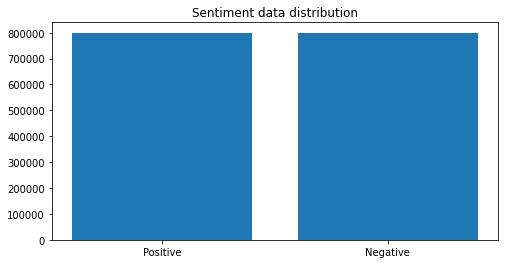

In [9]:
val_count=df.sentiment.value_counts()
val_count
plt.figure(figsize=(8,4))
plt.bar(val_count.index,val_count.values)
plt.title("Sentiment data distribution");

In [10]:
len(df.text)

1600000

From the graph understand that it is a balanced dataset 

In [11]:
import random
random_idx_list=[random.randint(1,len(df.text)) for i in range(10)]
df.loc[random_idx_list,:].head(10)

,sentiment,text
734420,Negative,"Reading: &quot;Convert Data, Files Online FREE..."
1393899,Positive,So bored with Physics revision :Z But looking ...
723071,Negative,@siahwalker I wish we could see you guys but ...
356093,Negative,"Rainy day in Calgary, we are getting snow over..."
368017,Negative,@akomuzikera we have one confirmed the two wa...
1527221,Positive,"@zunaid Ha, well there are different levels, l..."
1391851,Positive,going for sashimi buffet now
673068,Negative,WHAT IS SHE DOING RIGHT NOW???????? I WONDER.....
970231,Positive,@allikat i'm having so much fun digging out th...
1356617,Positive,@IamRonRon OH mmhmm lol j/k...nah i look like ...


The text have lof of unneccesory stuff. we need to get rid of them

#Text Preprocessing 

In [12]:
stop_words=stopwords.words('english')
stemmer=SnowballStemmer('english')
text_cleaning_re="@\S+|https?:\S|[^A-Za-z0-9]+"

In [13]:
def preprocess(text,stem=False):
  text=re.sub(text_cleaning_re,' ',str(text).lower()).strip()
  tokens=[]
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [14]:
df.text=df.text.apply(lambda x:preprocess(x))

clean and good to go


In [15]:
df.text

0          twitpic com 2y1zl awww bummer shoulda got davi...
1          upset update facebook texting might cry result...
2          dived many times ball managed save 50 rest go ...
3                           whole body feels itchy like fire
4                                           behaving mad see
                                 ...                        
1599995                        woke school best feeling ever
1599996    thewdb com cool hear old walt interviews blip ...
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, Length: 1600000, dtype: object

Positive and negative words

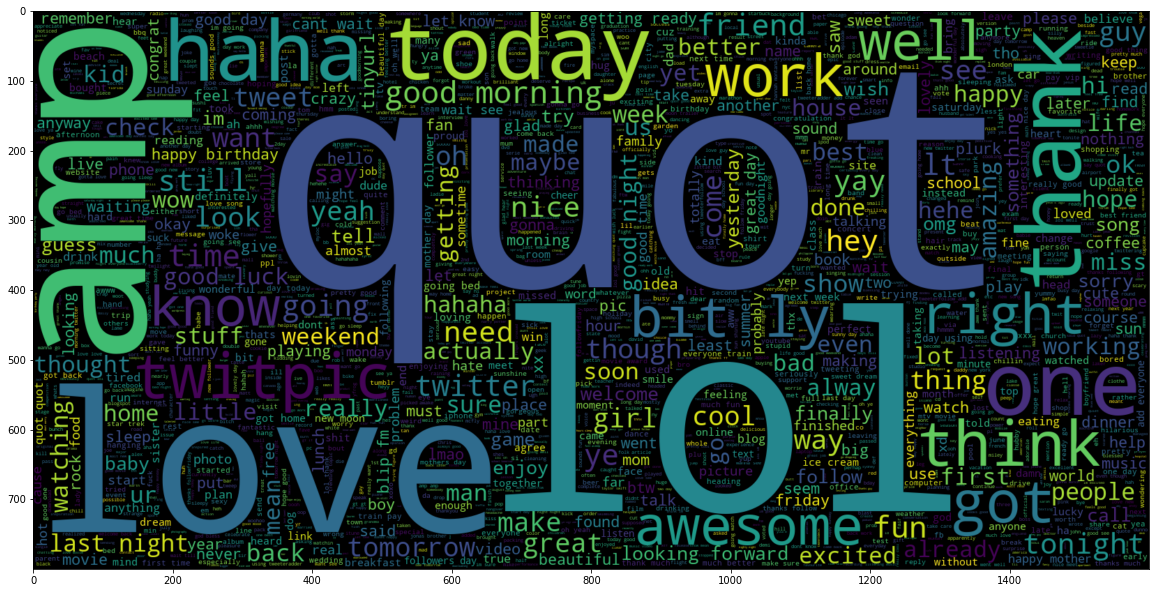

In [16]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

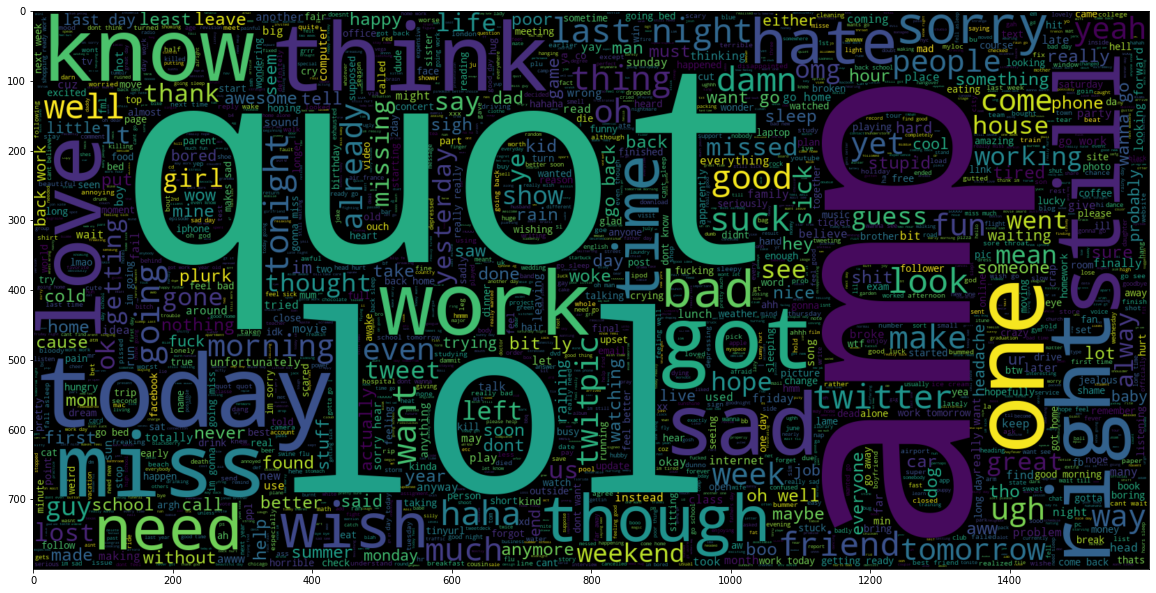

In [17]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

#Train Test Split

In [18]:
TRAIN_SIZE=0.8
MAX_NB_WORDS=100000
MAX_SEQUENCE_LENGTH=30

In [19]:
train_data,test_data=train_test_split(df,test_size=1-TRAIN_SIZE,random_state=7)
print("Train Data Size : ",len(train_data))
print("Train Data Size : ",len(test_data))

Train Data Size :  1280000
Train Data Size :  320000


In [20]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,twitpic com 5dflq amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


#Tokenization
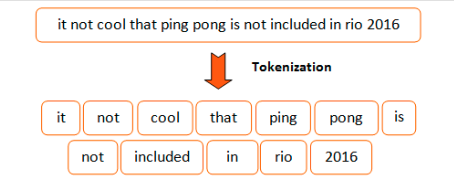

In [21]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 341204


In [22]:
from keras.preprocessing.sequence import pad_sequences
x_train=pad_sequences(tokenizer.texts_to_sequences(train_data.text),maxlen=MAX_SEQUENCE_LENGTH)
x_test=pad_sequences(tokenizer.texts_to_sequences(test_data.text),maxlen=MAX_SEQUENCE_LENGTH)
print("Traininf x shape",x_train.shape)
print("Testinfg x shape",x_test.shape)

Traininf x shape (1280000, 30)
Testinfg x shape (320000, 30)


In [23]:
labels=train_data.sentiment.unique().tolist()

In [24]:
labels

['Negative', 'Positive']

Label Encoding 

In [25]:
encoder=LabelEncoder()
encoder.fit(train_data.sentiment.to_list())
y_train=encoder.transform(train_data.sentiment.to_list())
y_test=encoder.transform(test_data.sentiment.to_list())


In [26]:
y_train

array([0, 0, 0, ..., 0, 1, 0])

In [27]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)


In [28]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [29]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [30]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-05-31 17:09:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-31 17:09:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-31 17:09:41--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [31]:
GLOVE_EMD='/content/glove.6B.300d.txt'
EMBEDDING_DIM=300
LR=1e-3
BATCH_SIZE=1024
EPOCHS=10
MODEL_PATH='/content/drive/MyDrive/datasets/best_model.hdf5'

In [32]:
embedding_index={}
f=open(GLOVE_EMD)
for line in f:
  values=line.split()
  word=value=values[0]
  coefs=np.asarray(values[1:],dtype='float32')
  embedding_index[word]=coefs
f.close()


In [33]:
print('Found %s word vectors.' %len(embedding_index))

Found 400000 word vectors.


In [34]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [35]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [36]:
from tensorflow.keras.layers import Conv1D,Bidirectional,LSTM,Dense,Input,Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [37]:
sequence_input=Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
embedding_sequence=embedding_layer(sequence_input)
x=SpatialDropout1D(0.2)(embedding_sequence)
x=Conv1D(64,5,activation='relu')(x)
x=Bidirectional(LSTM(64,dropout=0.2,recurrent_dropout=0.2))(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
outputs=Dense(1,activation='sigmoid')(x)
model=tf.keras.Model(sequence_input,outputs)

In [38]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
model.compile(optimizer=Adam(learning_rate=LR),loss='binary_crossentropy',metrics=['accuracy'])
ReduceLROnPlateau=ReduceLROnPlateau(factor=0.1,min_lr=0.01,monitor='val_loss',verbose=1)

In [39]:
print("Training on GPU..") if tf.test.is_gpu_available() else print("Training on cpu")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU..


In [40]:
history=model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_test,y_test),callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 172s 110ms/step - loss: 0.5189 - accuracy: 0.7396 - val_loss: 0.4838 - val_accuracy: 0.7643
Epoch 2/10
1250/1250 [==============================] - 136s 109ms/step - loss: 0.4871 - accuracy: 0.7626 - val_loss: 0.4711 - val_accuracy: 0.7731
Epoch 3/10
1250/1250 [==============================] - 136s 109ms/step - loss: 0.4768 - accuracy: 0.7695 - val_loss: 0.4659 - val_accuracy: 0.7761
Epoch 4/10
1250/1250 [==============================] - 137s 109ms/step - loss: 0.4705 - accuracy: 0.7733 - val_loss: 0.4620 - val_accuracy: 0.7786
Epoch 5/10
1250/1250 [==============================] - 135s 108ms/step - loss: 0.4656 - accuracy: 0.7768 - val_loss: 0.4636 - val_accuracy: 0.7791
Epoch 6/10
1250/1250 [==============================] - 136s 109ms/step - loss: 0.4626 - accuracy: 0.7783 - val_loss: 0.4599 - val_accuracy: 0.7800
Epoch 7/10
1250/1250 [==============================] - 135s 108ms/step - loss: 0.4597 - accuracy: 0.7798 - val_

#Model Evaluation

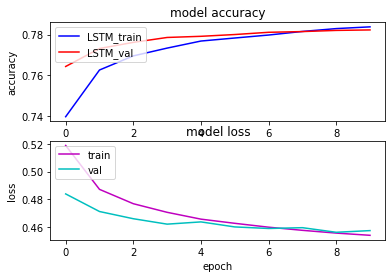

In [42]:
s,(at,al)=plt.subplots(2,1)
at.plot(history.history['accuracy'],c='b')
at.plot(history.history['val_accuracy'],c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

#loss
al.plot(history.history['loss'],c='m')
al.plot(history.history['val_loss'],c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [43]:
def decode_sentiment(score):
  return "Positive" if score>0.5 else "Negative"

scores=model.predict(x_test,verbose=1,batch_size=10000)
y_pred_1d=[decode_sentiment(score) for score in scores]

32/32 [==============================] - 4s 105ms/step


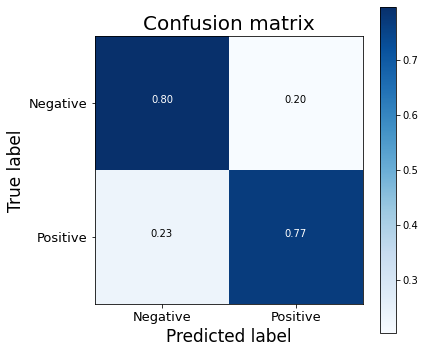

In [45]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [46]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.78      0.80      0.79    160542
    Positive       0.79      0.77      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

